## Import Modules

In [79]:
import pandas as pd
import numpy as np

from  cbcdb import DBManager
import datetime
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

## Read in Data

In [80]:
load_dotenv(find_dotenv())
db = DBManager()

In [81]:
sql = """
 select
    f.animal_id
    , f.breed
    , f.ani_age
    , f.datetime
    , f.weight
    , f.name
    , f.type
    , f.tracking_level
    , f.product_group
    , f.visit_more_than_once
    , f.rev_day_total
    , f.rank_
    , sum(f.revenue)                                                as revenue
    from (select
            t.animal_id
             , a.breed
             , max(date_diff('years', timestamp 'epoch' + a.date_of_birth * interval '1 second', current_date)) as ani_age
             , trunc(t.datetime_date)                                                                           as datetime
             , a.weight
             , p.name
             , p.type
             , p.tracking_level
             , p.product_group
             , case
                   when a.id in (select
                                    distinct x.animal_id
                                    from (
                                        select t.animal_id
                                                , trunc(t.datetime_date)  as date
                                                , sum(t.revenue)          as revenues
                                                , dense_rank()  over (partition by animal_id order by trunc(t.datetime_date) asc)              as rank_
                                           from bi.transactions t
                                                    left join bi.divisions d
                                                              on d.division_id = t.division_id
                                                    inner join bi.animals a
                                                               on a.id = t.animal_id
                                                                and a.location_id = t.location_id
                                                    inner join bi.products p
                                                               on t.product_id = p.ezyvet_id
                                                                   and t.location_id = p.location_id
                                                                   and p.is_medical = 1
                                           where is_dead = 0
                                             and a.active = 1
                                             and p.product_group != 'Surgical Services'
                                           group by 1, 2
                                           having  revenues > 100) x
                                    where x.rank_ > 1)
                    then 1 else 0 end                                                                       as visit_more_than_once
                , t.revenue                                                                                 as revenue
                , dense_rank() over (partition by t.animal_id order by datetime asc)                        as rank_
                , sum(t.revenue) over (partition by t.animal_id, trunc(t.datetime_date) )                   as rev_day_total

            from bi.transactions t
                     inner join bi.products p
                                on t.product_id = p.ezyvet_id
                                    and t.location_id = p.location_id
                                    and p.is_medical = 1
                     inner join bi.animals a
                                on a.id = t.animal_id
                     left join bi.contacts c
                               on a.contact_id = c.ezyvet_id
                                   and t.location_id = c.location_id
            where p.name not like '%Subscri%'
              and p.product_group != 'Surgical Services'
              and a.species like '%Dog%'
              and a.breed != '0.0'
            group by 1, 2, 4, 5, 6, 7, 8, 9, 10, 11) f
--where f.rev_day_total > 100
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12; """
df = db.get_sql_dataframe(sql)
df_ = df.copy()

2021-06-15 12:42:40,379| ERROR   | Password is required for key /Users/adhamsuliman/.ssh/id_rsa


## Exploratoy Data Analysis
#### Amount of time between first and second appointment


In [82]:
df_valid = df[df.datetime<datetime.date(datetime.date.today().year-1 , datetime.date.today().month+6, datetime.date.today().day)]
#df_valid = df[df.datetime<datetime.date(datetime.date.today().year-1 , datetime.date.today().month, datetime.date.today().day)]
df = df.merge(df_valid['animal_id']).copy()

len(df.animal_id.unique())

832

In [83]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.columns

Index(['animal_id', 'breed', 'ani_age', 'datetime', 'weight', 'name', 'type',
       'tracking_level', 'product_group', 'visit_more_than_once',
       'rev_day_total', 'rank_', 'revenue'],
      dtype='object')

(array([737485., 737516., 737546., 737577., 737607., 737638., 737669.,
        737699., 737730., 737760.]),
 <a list of 10 Text major ticklabel objects>)

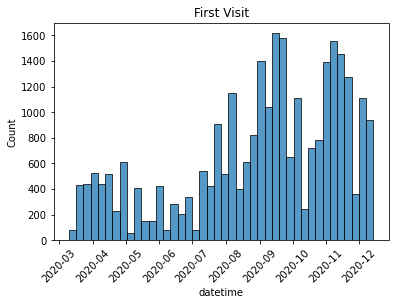

In [84]:
sns.histplot(data=df[df.rank_==1],x='datetime').set(title='First Visit')
plt.xticks(rotation=45)

([<matplotlib.axis.XTick at 0x7fc2c99cf670>,
 <a list of 10 Text major ticklabel objects>)

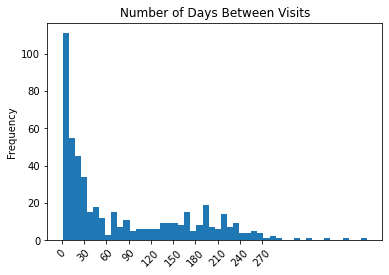

In [85]:
df_visit_1 = df[df.rank_ == 1]
df_visit_2 = df[df.rank_ == 2]
df_diff = df_visit_1[['animal_id','datetime']].merge(df_visit_2[['animal_id','datetime']], on='animal_id').drop_duplicates()
df_diff['date'] = df_diff.apply(lambda x: x.datetime_y -x.datetime_x, axis = 1 )
df_diff['date'].astype('timedelta64[D]').plot.hist(bins = 50).set(title='Number of Days Between Visits')
plt.xticks(np.arange(0, 300, 30), rotation=45)
#plt.yticks(np.arange(0,16,1))

In [86]:
df_species = df.breed.value_counts()

In [87]:
species = df_species.index.tolist()[:20]

In [88]:
#df_product = pd.get_dummies(df1.name)
df_product_group = pd.get_dummies(df.product_group)
#df_breed = pd.get_dummies(df.breed)
#df_ = pd.concat([df1,df_product,df_species, df_product_group]).fillna(0).drop(columns = ['species','name','product_group'])
df_ = pd.concat([df, df_product_group], axis =1).drop(columns = ['product_group']) #, axis = 1
df_

,animal_id,breed,ani_age,datetime,weight,name,type,tracking_level,visit_more_than_once,rev_day_total,...,Medications - Injectable,Medications - Oral,Medications - Topical,Parasite Control,Professional Services,Promotions,RX Diets,Supplements/OTCs,Vaccinations,Wellness Plan Fees
0,299,Siberian Husky,5.0,2020-03-20,36.4,Leptospirosis (1 year),Vaccination,No,0,93.25,...,0,0,0,0,0,0,0,0,1,0
1,299,Siberian Husky,5.0,2020-03-20,36.4,Leptospirosis (1 year),Vaccination,No,0,93.25,...,0,0,0,0,0,0,0,0,1,0
2,299,Siberian Husky,5.0,2020-03-20,36.4,Leptospirosis (1 year),Vaccination,No,0,93.25,...,0,0,0,0,0,0,0,0,1,0
3,299,Siberian Husky,5.0,2020-03-20,36.4,Leptospirosis (1 year),Vaccination,No,0,93.25,...,0,0,0,0,0,0,0,0,1,0
4,299,Siberian Husky,5.0,2020-03-20,36.4,Leptospirosis (1 year),Vaccination,No,0,93.25,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84521,5698,Golden Doodle,5.0,2021-06-05,55.0,Dental cleaning recommended,Standard,No,0,137.00,...,0,0,0,0,0,0,0,0,0,0
84522,5698,Golden Doodle,5.0,2021-06-05,55.0,Dental cleaning recommended,Standard,No,0,137.00,...,0,0,0,0,0,0,0,0,0,0
84523,5698,Golden Doodle,5.0,2021-06-05,55.0,FVRCP (1 year),Vaccination,No,0,137.00,...,0,0,0,0,0,0,0,0,1,0
84524,5698,Golden Doodle,5.0,2021-06-05,55.0,FVRCP (1 year),Vaccination,No,0,137.00,...,0,0,0,0,0,0,0,0,1,0


In [89]:
breed = df_.breed.value_counts().index.tolist()[:10]
breed

['Beagle',
 'Yorkshire Terrier',
 'Shih Tzu',
 'Labrador Retriever',
 'German Shepherd Dog',
 'Boxer',
 'Shepherd Mix',
 'French Bulldog',
 'American Eskimo Dog',
 'schnauzer/terrier']

German Shepherd Dog    30
Yorkshire Terrier      27
Labrador Retriever     27
Shih Tzu               24
Beagle                 14
Boxer                  12
French Bulldog         11
Shepherd Mix            7
American Eskimo Dog     1
schnauzer/terrier       1
Name: breed, dtype: int64


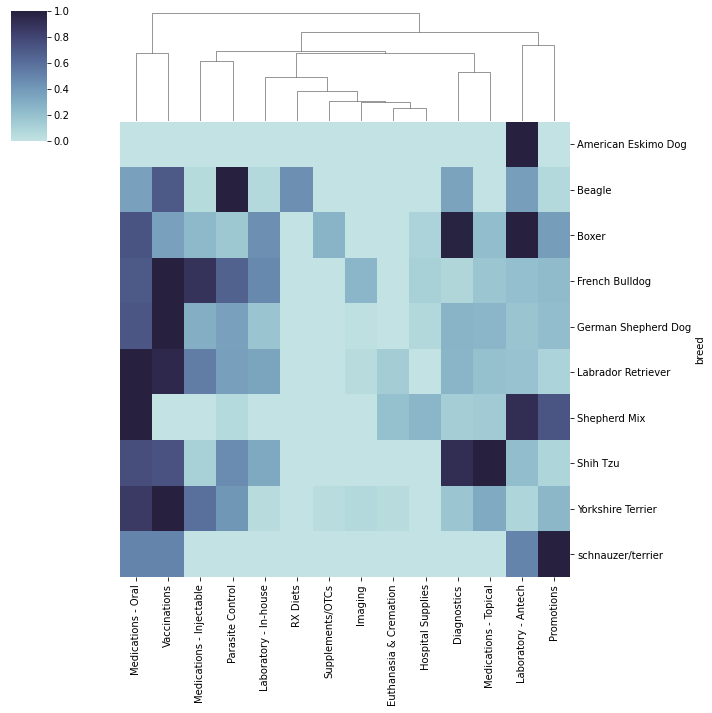

In [90]:
df_dog = df_[(df_['rank_'] == 1) & (df_.breed.isin(breed))]
df_final = df_dog.groupby(['animal_id','breed'], as_index = False)['Diagnostics',
       'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
       'Laboratory - Antech', 'Laboratory - In-house',
       'Medications - Injectable', 'Medications - Oral',
       'Medications - Topical', 'Parasite Control', #'Professional Services',
       'Promotions', 'RX Diets',  'Supplements/OTCs',
        'Vaccinations'].sum() #, 'Wellness Plan Fees', 'Dentistry & Oral Surgery', 'To Print Burkett',
#df_final.rename(columns = {'rank_':'Number of Visits'}, inplace=True)
print(df_final['breed'].value_counts())
df_final_ = pd.pivot_table(df_final, 
                            values = ['Diagnostics',
                            'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
                            'Laboratory - Antech', 'Laboratory - In-house',
                            'Medications - Injectable', 'Medications - Oral',
                            'Medications - Topical', 'Parasite Control', #'Professional Services',
                            'Promotions', 'RX Diets',  'Supplements/OTCs',
                            'Vaccinations'], 
                            index = 'breed')
color = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.clustermap(df_final_, 
                standard_scale=0,
                cmap=color,
                robust=True,
                row_cluster=False)
plt.show()

Run once for dogs and once for cats

German Shepherd Dog    18
Labrador Retriever     16
Yorkshire Terrier      15
Shih Tzu               15
Boxer                  11
Beagle                  7
French Bulldog          6
Shepherd Mix            5
American Eskimo Dog     1
schnauzer/terrier       1
Name: breed, dtype: int64


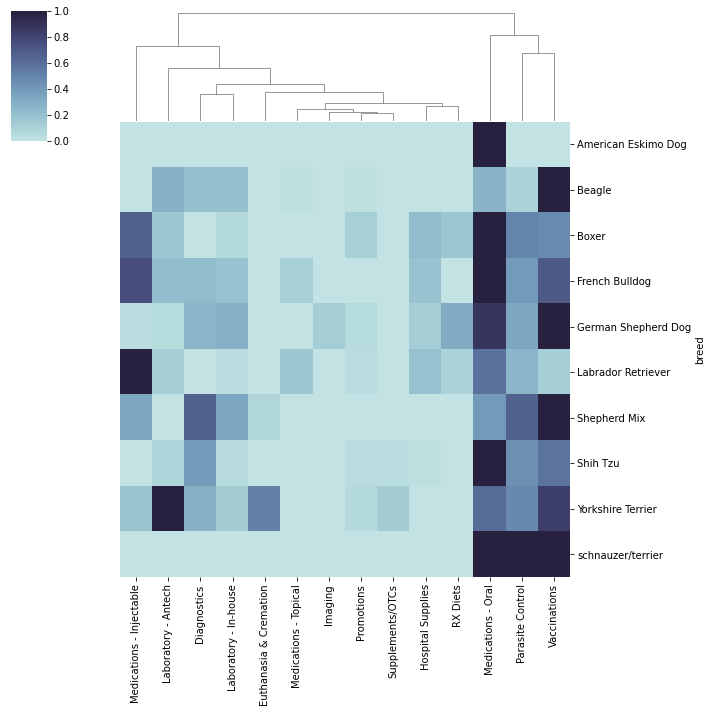

In [91]:
df_dog = df_[(df_['rank_'] == 2) & (df_.breed.isin(breed))]
df_final = df_dog.groupby(['animal_id','breed'], as_index = False)['Diagnostics',
       'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
       'Laboratory - Antech', 'Laboratory - In-house',
       'Medications - Injectable', 'Medications - Oral',
       'Medications - Topical', 'Parasite Control', #'Professional Services',
       'Promotions', 'RX Diets',  'Supplements/OTCs',
        'Vaccinations'].sum() #, 'Wellness Plan Fees', 'Dentistry & Oral Surgery', 'To Print Burkett',
#df_final.rename(columns = {'rank_':'Number of Visits'}, inplace=True)
print(df_final['breed'].value_counts())
df_final_ = pd.pivot_table(df_final, 
                            values = ['Diagnostics',
                            'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
                            'Laboratory - Antech', 'Laboratory - In-house',
                            'Medications - Injectable', 'Medications - Oral',
                            'Medications - Topical', 'Parasite Control', #'Professional Services',
                            'Promotions', 'RX Diets',  'Supplements/OTCs',
                            'Vaccinations'], 
                            index = 'breed')
color = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.clustermap(df_final_, 
                standard_scale=0,
                cmap=color,
                robust=True,
                row_cluster=False)
plt.show()

German Shepherd Dog    12
Shih Tzu               10
Labrador Retriever     10
Yorkshire Terrier       8
Boxer                   8
Beagle                  7
French Bulldog          6
Shepherd Mix            4
American Eskimo Dog     1
schnauzer/terrier       1
Name: breed, dtype: int64


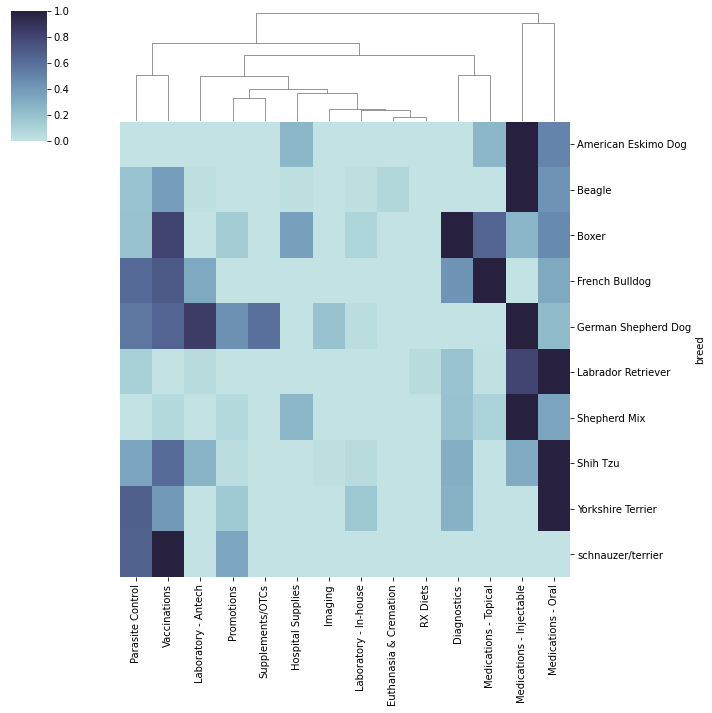

In [92]:
df_dog = df_[(df_['rank_'] == 3) & (df_.breed.isin(breed))]
df_final = df_dog.groupby(['animal_id','breed'], as_index = False)['Diagnostics',
       'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
       'Laboratory - Antech', 'Laboratory - In-house',
       'Medications - Injectable', 'Medications - Oral',
       'Medications - Topical', 'Parasite Control', #'Professional Services',
       'Promotions', 'RX Diets',  'Supplements/OTCs',
        'Vaccinations'].sum() #, 'Wellness Plan Fees', 'Dentistry & Oral Surgery', 'To Print Burkett',
#df_final.rename(columns = {'rank_':'Number of Visits'}, inplace=True)
print(df_final['breed'].value_counts())
df_final_ = pd.pivot_table(df_final, 
                            values = ['Diagnostics',
                            'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
                            'Laboratory - Antech', 'Laboratory - In-house',
                            'Medications - Injectable', 'Medications - Oral',
                            'Medications - Topical', 'Parasite Control', #'Professional Services',
                            'Promotions', 'RX Diets',  'Supplements/OTCs',
                            'Vaccinations'], 
                            index = 'breed')
color = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.clustermap(df_final_, 
                standard_scale=0,
                cmap=color,
                robust=True,
                row_cluster=False)
plt.show()

In [93]:
df_cat = df_[(df_['Feline (Cat)'] ==1) & (df_['rank_'] <= 2)]
df_final = df_cat.groupby(['animal_id','rank_'], as_index = False)['Diagnostics',
       'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
       'Laboratory - Antech', 'Laboratory - In-house',
       'Medications - Injectable', 'Medications - Oral',
       'Medications - Topical', 'Parasite Control', #'Professional Services',
       'Promotions', 'RX Diets',  'Supplements/OTCs',
        'Vaccinations'].sum() #, 'Wellness Plan Fees', 'Dentistry & Oral Surgery', 'To Print Burkett',
df_final.rename(columns = {'rank_':'Number of Visits'}, inplace=True)
print(df_final['Number of Visits'].value_counts())
df_final_ = pd.pivot_table(df_final, 
                            values = ['Diagnostics',
                            'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
                            'Laboratory - Antech', 'Laboratory - In-house',
                            'Medications - Injectable', 'Medications - Oral',
                            'Medications - Topical', 'Parasite Control', #'Professional Services',
                            'Promotions', 'RX Diets',  'Supplements/OTCs',
                            'Vaccinations'], 
                            index = 'Number of Visits')

KeyError: 'Feline (Cat)'

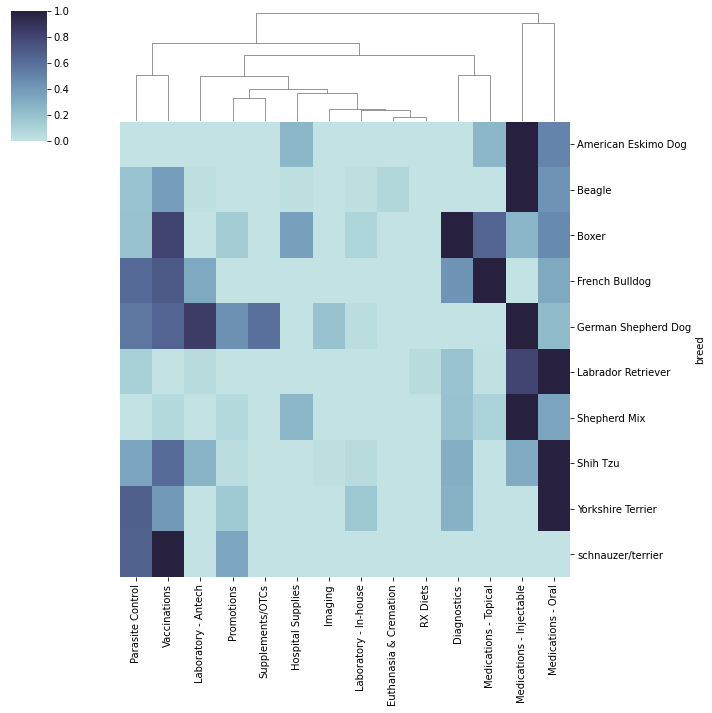

In [94]:
color = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.clustermap(df_final_, 
                standard_scale=0,
                cmap=color,
                robust=True,
                row_cluster=False)
plt.show()

In [95]:
df_final.animal_id.nunique()

67

In [96]:
df_final = df_.groupby(['animal_id','visit_more_than_once','rank_'], as_index = False)[ 'Diagnostics',
       'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
       'Laboratory - Antech', 'Laboratory - In-house',
       'Medications - Injectable', 'Medications - Oral',
       'Medications - Topical', 'Parasite Control', 'Professional Services',
       'Promotions', 'RX Diets',  'Supplements/OTCs',
        'Vaccinations'].sum() 
        #'Canine (Dog)',       'Feline (Cat)',
df_first_visit = df_final[df_final.rank_==1]
X = df_first_visit[[ 'Diagnostics',
       'Euthanasia & Cremation', 'Hospital Supplies', 'Imaging',
       'Laboratory - Antech', 'Laboratory - In-house',
       'Medications - Injectable', 'Medications - Oral',
       'Medications - Topical', 'Parasite Control', 'Professional Services',
       'Promotions', 'RX Diets',  'Supplements/OTCs',
        'Vaccinations']]
y = df_first_visit['visit_more_than_once'].apply(lambda x: int(x))
#X.columns[X.nunique() == 1]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = .2,
                                                    random_state = 42)

In [98]:
# Below will fail with a perfect separation error
res = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
res.params

#res2 = sm.GLM(y_train, Xs, family=sm.families.Binomial()).fit_regularized(L1_wt=0.0, alpha=0.1)
#params = res2.params

Diagnostics                  0.083953
Euthanasia & Cremation     -21.177055
Hospital Supplies            0.024805
Imaging                     -0.123200
Laboratory - Antech          0.108863
Laboratory - In-house        0.000751
Medications - Injectable    -0.053851
Medications - Oral           0.054645
Medications - Topical        0.002832
Parasite Control             0.060643
Professional Services       -0.310637
Promotions                  -0.143308
RX Diets                    -6.893933
Supplements/OTCs             0.098850
Vaccinations                -0.023774
dtype: float64

In [99]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     visit_more_than_once   No. Observations:                  665
Model:                              GLM   Df Residuals:                      650
Model Family:                  Binomial   Df Model:                           14
Link Function:                    logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -272.57
Date:                  Tue, 15 Jun 2021   Deviance:                       545.13
Time:                          12:42:56   Pearson chi2:                 1.96e+05
No. Iterations:                      25                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Diagnostics                  0.0840      0.042      2.006      0.045       0.002       0.166
Euthanasia & Cremation     -21.1771    1.7e+04     -0.001      0.999   -3.34e+04    3.33e+04
Hospital Supplies            0.0248      0.098      0.252      0.801      -0.168       0.218
Imaging                     -0.1232      0.159     -0.773      0.440      -0.436       0.189
Laboratory - Antech          0.1089      0.037      2.932      0.003       0.036       0.182
Laboratory - In-house        0.0008      0.062      0.012      0.990      -0.120       0.122
Medications - Injectable    -0.0539      0.038     -1.427      0.153      -0.128       0.020
Medications - Oral           0.0546      0.021      2.612      0.009       0.014       0.096
Medications - Topical        0.0028      0.038      0.074      0.941      -0.072       0.078
Parasite Control             0.0606      0.030      2.002      0.045       0.001       0.120
Professional Services       -0.3106      0.041     -7.617      0.000      -0.391      -0.231
Promotions                  -0.1433      0.075     -1.908      0.056      -0.291       0.004
RX Diets                    -6.8939   8593.932     -0.001      0.999   -1.69e+04    1.68e+04
Supplements/OTCs             0.0989      0.110      0.899      0.369      -0.117       0.314
Vaccinations                -0.0238      0.024     -0.994      0.320      -0.071       0.023
============================================================================================
"""

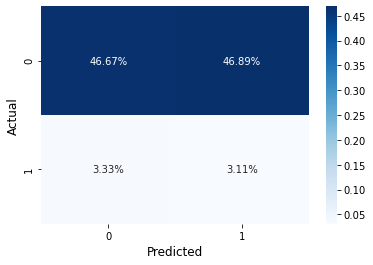

In [78]:
#Generate predictions with the model using our X values
y_pred = res.predict(X_test)
y_pred = y_pred.apply(lambda x: 1 if x > Find_Optimal_Cutoff(y_test, y_pred)[0] else 0)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.xlabel('Predicted', size = 'large')
plt.ylabel('Actual', size = 'large')
plt.show()

In [ ]:
model = Sequential()
model.add(Dense(32, input_dim=17, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model.fit(X_train,
            y_train,
            epochs = 100,
            batch_size = 10,
            validation_split = .2,
            callbacks = [es])

In [ ]:
#Generate predictions with the model using our X values
y_pred = model.predict(X_test)
y_pred = y_pred.ravel().tolist()
y_pred_ = [1 if y > Find_Optimal_Cutoff(y_test, y_pred)[0] else 0 for y in y_pred ]

cf_matrix = confusion_matrix(y_test, y_pred_)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues')